In [4]:
# importing libraries
import json
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from scipy import spatial
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import gensim
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
!pwd

/home2/rodosingh/AssignmentsProjects/Assignment-2-NLP/2021701028


# **Section 1:- Training**

# Question 1

In [8]:
# loading data. Consider changing the path to the actual path where file is present
data = []
with open('/home2/rodosingh/AssignmentsProjects/Assignment-2-NLP/reviews_Electronics_5.json') as file:
    for line in tqdm(file):
        data.append(''.join(ch if ch.isalnum() else ' ' for ch in json.loads(line)['reviewText'].lower()))
    file.close()

1689188it [01:59, 14188.96it/s]


In [9]:
len(data)

1689188

In [10]:
data[0]

'we got this gps for my husband who is an  otr  over the road trucker   very impressed with the shipping time  it arrived a few days earlier than expected     within a week of use however it started freezing up    could of just been a glitch in that unit   worked great when it worked   will work great for the normal person as well but does have the  trucker  option   the big truck routes   tells you when a scale is coming up ect      love the bigger screen  the ease of use  the ease of putting addresses into memory   nothing really bad to say about the unit with the exception of it freezing which is probably one in a million and that s just my luck   i contacted the seller and within minutes of my email i received a email back with instructions for an exchange  very impressed all the way around '

In [9]:
# Creating word frequency dict
words_freq = defaultdict(int)
for line in tqdm(data):
    line = line.split()
    for word in line:
        words_freq[word]+=1

100%|██████████| 1689188/1689188 [01:05<00:00, 25664.16it/s]


In [10]:
# Data after removing less frequent words
data_2 = []
for sentence in tqdm(data):
    data_2.append(' '.join([word for word in sentence.split() if words_freq[word]>4]))

100%|██████████| 1689188/1689188 [00:58<00:00, 29043.31it/s]


In [11]:
# Creating count vectorizer matrix to make count matrix
vectorizer = CountVectorizer()
vectorized_mat = vectorizer.fit_transform(data_2)

token_list = vectorizer.get_feature_names()

In [12]:
# Saving token list to a txt file
with open("models/tokens_list.txt", "w") as outfile:
    outfile.write("\n".join(token_list))

In [13]:
vectorized_mat.shape

(1689188, 100679)

In [15]:
# Creating co-occurence matrix
co_occ_mat = vectorized_mat.T*vectorized_mat

In [16]:
co_occ_mat.setdiag(0)

In [17]:
co_occ_mat.shape

(100679, 100679)

In [18]:
# Saving co-occurence matrix to prevent crashing the ram
sparse.save_npz("models/co_occurence.npz", co_occ_mat)

In [2]:
# Load the saved co-occurence matrix
# Consider restarting the server if you are running the cell from training section as it might crash the server
co_occ_mat = sparse.load_npz("models/co_occurence.npz")

In [3]:
# Create svd matrix and take top n features, here 256 is used
svd = TruncatedSVD(n_components=256)
svd_mat = svd.fit_transform(co_occ_mat)

In [4]:
svd_mat.shape

(100679, 256)

In [5]:
np.savetxt('models/svd_matrix.txt', svd_mat)

# **Section 2:- Inference**

In [4]:
# Read token list file
token_list = []
with open("models/tokens_list.txt", "r") as outfile:
    for line in outfile:
        token_list.append(line.strip('\n'))

In [5]:
# Read svd matrix
svd_mat = np.loadtxt('models/svd_matrix.txt')

In [6]:
# Function to calculate the top10 words and plot using t-SNE
def plot_top10_words(word, token_list, svd_mat):

    def tsne_plot(results):
        words = []
        embeds = []

        for res in results:
            embeds.append(res[1])
            words.append(res[0])
        
        tsne_model = TSNE(init='pca')
        res_embeds = tsne_model.fit_transform(embeds)

        x_axis_val = []
        y_axis_val = []
        for val in res_embeds:
            x_axis_val.append(val[0])
            y_axis_val.append(val[1])
            
        plt.figure(figsize=(10, 10)) 
        for i in range(len(x_axis_val)):
            plt.scatter(x_axis_val[i],y_axis_val[i])
            plt.annotate(words[i],
                        xy=(x_axis_val[i],y_axis_val[i]),
                        xytext=(5, 2),
                        textcoords='offset points',
                        ha='right',
                        va='bottom')
        plt.show()
    
    word_index = token_list.index(word)
    word_embed = svd_mat[word_index]
    res = {}
    for i, embed in tqdm(enumerate(svd_mat)):
        if i!=word_index:
            res[i] = [1 - spatial.distance.cosine(svd_mat[i], word_embed), svd_mat[i]]


    results = []
    for t in sorted(res.items(), key=lambda item: item[1][0], reverse=True)[0:10]:
        results.append([token_list[t[0]], t[1][1]])

    print('Word:-', word)
    print('Words:-', end='\t')
    for res in results:
        print(res[0], end=', ')
    print()

    tsne_plot(results) 

# Question 3

100679it [00:04, 23751.11it/s]


Word:- payment
Words:-	fee, fees, billing, expire, membership, contract, redeem, monthly, service, policies, 


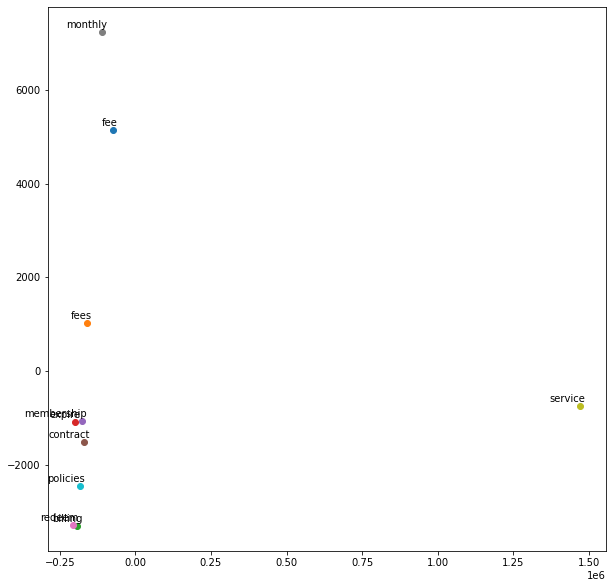

In [7]:
plot_top10_words('payment', token_list, svd_mat)

100679it [00:04, 22547.16it/s]


Word:- laptop
Words:-	runs, netbook, notebook, machine, desktop, flies, win, daily, computer, macbook, 


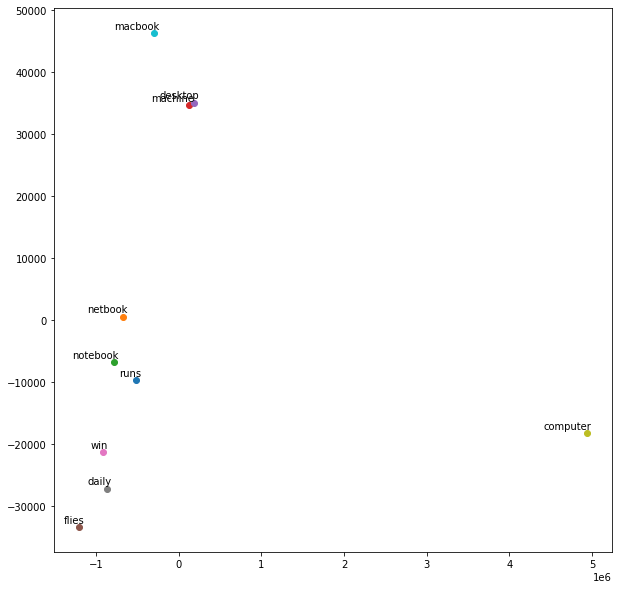

In [8]:
plot_top10_words('laptop', token_list, svd_mat)

100679it [00:04, 23097.30it/s]


Word:- music
Words:-	hear, apt, tunes, exercise, disturb, blasting, stereo, mixes, sing, heard, 


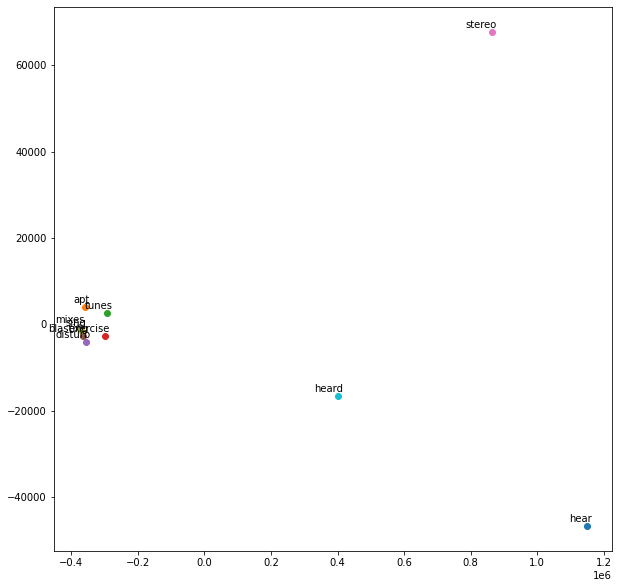

In [9]:
plot_top10_words('music', token_list, svd_mat)

100679it [00:04, 23146.47it/s]


Word:- processor
Words:-	core, intensive, quad, processors, horsepower, graphics, i5, tasks, scores, upgradeable, 


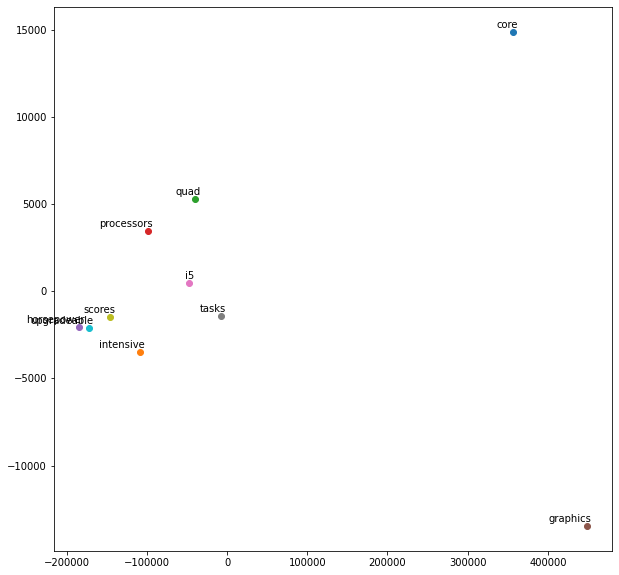

In [10]:
plot_top10_words('processor', token_list, svd_mat)

100679it [00:04, 23016.93it/s]


Word:- screen
Words:-	itself, flipping, counter, down, lastly, minor, paper, showing, leaves, off, 


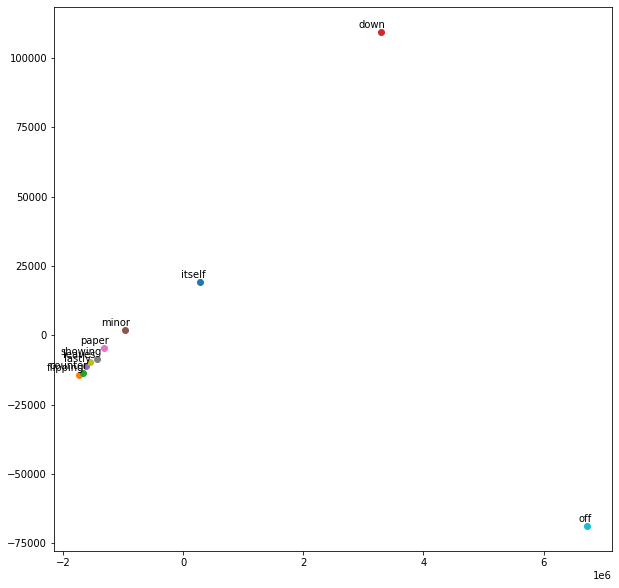

In [11]:
plot_top10_words('screen', token_list, svd_mat)

# Question 4

In [12]:
# Function to calculate the top10 words and plot using t-SNE
def plot_top10_words_word2vec(word, cbow_own):

    def tsne_plot(results):
        words = []
        embeds = []

        for res in results:
            embeds.append(res[1])
            words.append(res[0])
        
        tsne_model = TSNE(init='pca')
        res_embeds = tsne_model.fit_transform(embeds)

        x_axis_val = []
        y_axis_val = []
        for val in res_embeds:
            x_axis_val.append(val[0])
            y_axis_val.append(val[1])
            
        plt.figure(figsize=(10, 10)) 
        for i in range(len(x_axis_val)):
            plt.scatter(x_axis_val[i],y_axis_val[i])
            plt.annotate(words[i],
                        xy=(x_axis_val[i],y_axis_val[i]),
                        xytext=(5, 2),
                        textcoords='offset points',
                        ha='right',
                        va='bottom')
        plt.show()
    
    similar_words = cbow_own.most_similar(positive=[word], topn = 10)
    res = {}
    for i, embed in tqdm(enumerate(similar_words)):
        res[embed[0]] = [embed[1], cbow_own[embed[0]]]


    results = []
    for t in sorted(res.items(), key=lambda item: item[1][0], reverse=True)[0:10]:
        results.append([t[0], t[1][1]])

    print('Word:-', word)
    print('Words:-', end='\t')
    for res in results:
        print(res[0], end=', ')
    print()

    tsne_plot(results)

100679it [00:04, 22742.16it/s]


Word:- camera
Words:-	frame, handheld, hunting, backgrounds, stops, minimum, variable, practice, 2x, close, 


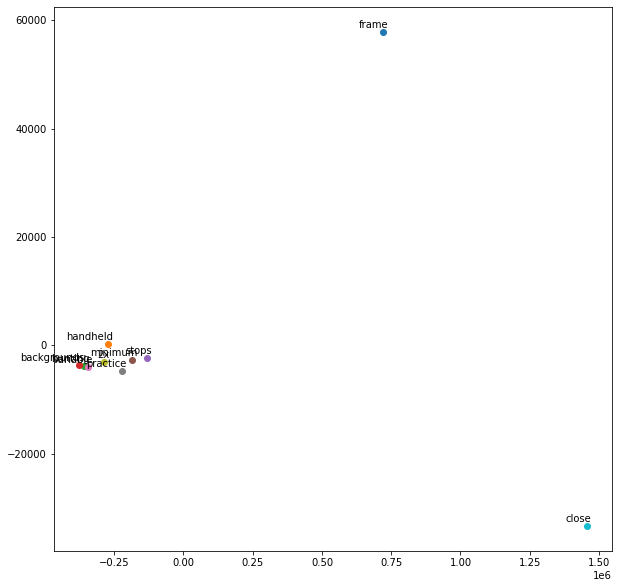

In [13]:
plot_top10_words('camera', token_list, svd_mat)

In [14]:
# if pretrained word2vec not present uncomment below code and run this cell

# !wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

# !gzip -d GoogleNews-vectors-negative300.bin.gz

In [15]:
# load pretrained model
# Consider restarting before running this cell as this might crash server
pretrained_word2vec = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

10it [00:00, 8476.77it/s]


Word:- camera
Words:-	cameras, Wagging_finger, camera_lens, camcorder, Camera, Canon_digital_SLR, Cameras, Nikon_D####_digital_SLR, tripod, EyeToy_USB, 


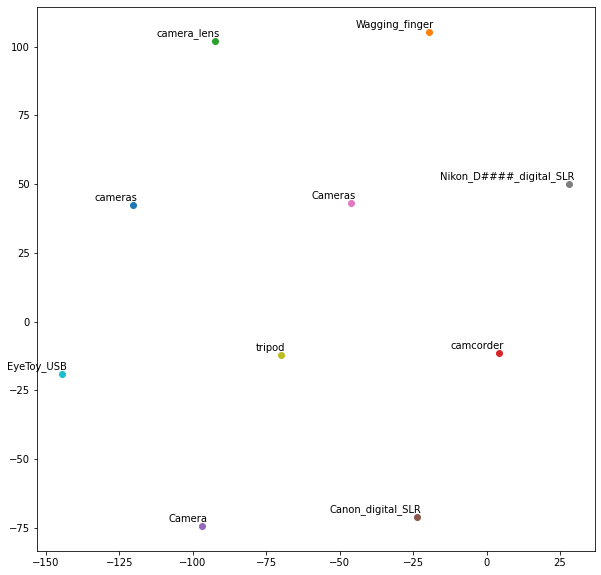

In [16]:
plot_top10_words_word2vec('camera', pretrained_word2vec)